In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from scipy import stats
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC

In [38]:
class AnalizadorEquipos:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.modelo_ml = RandomForestClassifier(
            random_state=42,
            class_weight='balanced',
            n_estimators=100
        )
        self.modelo_dl = None
        self.stats_summary = None
        
    def cargar_datos(self, ruta_archivo):
        """
        Carga y prepara los datos del CSV
        """
        self.datos = pd.read_csv(ruta_archivo)
        self.datos.columns = ['temp_aire', 'temp_proceso', 'vibracion', 
                            'horas_operacion', 'tipo_fallo']
        
        # Convertir los tipos de fallo a valores numéricos
        self.datos['tipo_fallo_num'] = self.label_encoder.fit_transform(self.datos['tipo_fallo'])
        
        # Crear mapeo de etiquetas
        self.fallo_nombres = dict(enumerate(self.label_encoder.classes_))
        self.fallo_numeros = {v: k for k, v in self.fallo_nombres.items()}
        
        return self.datos
    
    def analisis_estadistico(self):
        """
        Realiza análisis estadístico detallado de los datos
        """
        # Crear DataFrame numérico para correlaciones
        datos_numericos = self.datos.copy()
        datos_numericos['tipo_fallo'] = datos_numericos['tipo_fallo_num']
        
        # Estadísticas descriptivas por tipo de fallo
        stats_by_failure = {}
        for fallo in self.fallo_nombres.values():
            subset = self.datos[self.datos['tipo_fallo'] == fallo]
            stats_by_failure[fallo] = {
                'count': len(subset),
                'temp_aire_mean': subset['temp_aire'].mean(),
                'temp_proceso_mean': subset['temp_proceso'].mean(),
                'vibracion_mean': subset['vibracion'].mean(),
                'horas_mean': subset['horas_operacion'].mean(),
                'temp_aire_std': subset['temp_aire'].std(),
                'temp_proceso_std': subset['temp_proceso'].std(),
                'vibracion_std': subset['vibracion'].std(),
                'horas_std': subset['horas_operacion'].std()
            }
        
        # Correlaciones usando solo variables numéricas
        correlaciones = datos_numericos[['temp_aire', 'temp_proceso', 'vibracion', 
                                       'horas_operacion', 'tipo_fallo']].corr()
        
        self.stats_summary = {
            'por_fallo': pd.DataFrame(stats_by_failure).T,
            'correlaciones': correlaciones
        }
        
        return self.stats_summary
    
    def visualizar_estadisticas(self):
        """
        Genera visualizaciones estadísticas
        """
        plt.style.use('seaborn-v0_8-darkgrid')
        
        # 1. Distribución de tipos de fallo
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        fallo_counts = self.datos['tipo_fallo'].value_counts()
        sns.barplot(x=fallo_counts.index, y=fallo_counts.values)
        plt.xticks(rotation=45)
        plt.title('Distribución de Tipos de Fallo')
        plt.xlabel('Tipo de Fallo')
        plt.ylabel('Cantidad')
        
        # 2. Boxplots de variables por tipo de fallo
        plt.subplot(2, 2, 2)
        sns.boxplot(data=self.datos, x='tipo_fallo', y='vibracion')
        plt.xticks(rotation=45)
        plt.xlabel('Tipo de Fallo')
        plt.ylabel('Nivel de Vibración')
        plt.title('Vibración por Tipo de Fallo')
        
        # 3. Temperatura vs Horas de operación
        plt.subplot(2, 2, 3)
        sns.scatterplot(data=self.datos, x='horas_operacion', y='temp_proceso',
                       hue='tipo_fallo', palette='deep')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title('Temperatura de Proceso vs Horas de Operación')
        
        # 4. Correlaciones
        plt.subplot(2, 2, 4)
        sns.heatmap(self.stats_summary['correlaciones'], annot=True, cmap='coolwarm')
        plt.title('Matriz de Correlaciones')
        
        plt.tight_layout()
        plt.show()
        
        # Gráfico adicional: Distribución de variables por tipo de fallo
        plt.figure(figsize=(15, 5))
        variables = ['temp_aire', 'temp_proceso', 'vibracion']
        for i, var in enumerate(variables):
            plt.subplot(1, 3, i+1)
            for fallo in self.datos['tipo_fallo'].unique():
                subset = self.datos[self.datos['tipo_fallo'] == fallo]
                sns.kdeplot(data=subset[var], label=fallo)
            plt.title(f'Distribución de {var}')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    
    def entrenar_modelos(self):
        """
        Entrena modelos de ML y DL con mejor manejo de desbalance
        """
        # Preparar datos
        X = self.datos.drop(['tipo_fallo', 'tipo_fallo_num'], axis=1)
        y = self.datos['tipo_fallo_num']
        
        # División de datos
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)
        
        # Escalado
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Aplicar SMOTE para balancear datos de entrenamiento
        #smote = BorderlineSMOTE(random_state=42, k_neighbors=4)
        #smote = SMOTE(random_state=42, k_neighbors=5)
        min_samples = min(Counter(y_train).values())
        k_neighbors = min(min_samples - 1, 5)  # Asegura que k_neighbors no supere min_samples - 1

        self.modelo_ml = Pipeline([
            ('smote', SMOTE(random_state=42, k_neighbors=k_neighbors)),
            ('classifier', self.modelo_ml)
        ])
        self.modelo_ml.fit(X_train_scaled, y_train)

        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
        
        # Modelo DL con arquitectura mejorada
        n_classes = len(self.fallo_nombres)
        n_features = X_train.shape[1]
        
        # Calcular class weights para DL
        class_weights = dict(enumerate(len(y)/(n_classes*np.bincount(y))))
        
        self.modelo_dl = Sequential([
            Dense(128, activation='relu', input_shape=(n_features,)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(n_classes, activation='softmax')
        ])
        
        # Compilar con focal loss para mejor manejo de desbalance
        self.modelo_dl.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy', 
                    AUC(multi_label=True, num_labels=n_classes)]
        )
        
        # Callbacks para mejor entrenamiento
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5
            )
        ]
        
        # Entrenar DL
        history = self.modelo_dl.fit(
            X_train_balanced, y_train_balanced,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            class_weight=class_weights,
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluación
        y_pred_ml = self.modelo_ml.predict(X_test_scaled)
        y_pred_dl = np.argmax(self.modelo_dl.predict(X_test_scaled), axis=1)
        
        # Convertir etiquetas
        y_test_names = [self.fallo_nombres[i] for i in y_test]
        y_pred_ml_names = [self.fallo_nombres[i] for i in y_pred_ml]
        y_pred_dl_names = [self.fallo_nombres[i] for i in y_pred_dl]
        
        # Visualizaciones mejoradas
        self._plot_confusion_matrices(y_test_names, y_pred_ml_names, y_pred_dl_names)
        self._plot_training_history(history)
        
        # Imprimir reportes
        print("\nReporte de Clasificación - Random Forest con SMOTE:")
        print(classification_report(y_test_names, y_pred_ml_names))
        
        print("\nReporte de Clasificación - Deep Learning con Balanceo:")
        print(classification_report(y_test_names, y_pred_dl_names))
        
        return {
            'history': history.history,
            'y_test': y_test_names,
            'y_pred_ml': y_pred_ml_names,
            'y_pred_dl': y_pred_dl_names
        }
    
    def _plot_confusion_matrices(self, y_test_names, y_pred_ml_names, y_pred_dl_names):
        """
        Visualiza matrices de confusión con mejor formato
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        ConfusionMatrixDisplay.from_predictions(
            y_test_names, y_pred_ml_names,
            ax=ax1,
            cmap='Blues',
            normalize='true'
        )
        ax1.set_title('Matriz de Confusión Normalizada\nRandom Forest + SMOTE')
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
        
        ConfusionMatrixDisplay.from_predictions(
            y_test_names, y_pred_dl_names,
            ax=ax2,
            cmap='Blues',
            normalize='true'
        )
        ax2.set_title('Matriz de Confusión Normalizada\nDeep Learning Balanceado')
        plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    def _plot_training_history(self, history):
        """
        Visualiza el historial de entrenamiento del modelo DL
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot accuracy
        ax1.plot(history.history['accuracy'], label='train')
        ax1.plot(history.history['val_accuracy'], label='validation')
        ax1.set_title('Accuracy durante entrenamiento')
        ax1.set_xlabel('Época')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        
        # Plot loss
        ax2.plot(history.history['loss'], label='train')
        ax2.plot(history.history['val_loss'], label='validation')
        ax2.set_title('Loss durante entrenamiento')
        ax2.set_xlabel('Época')
        ax2.set_ylabel('Loss')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

    def predecir_fallo(self, nuevos_datos):
        """
        Predice la probabilidad de cada tipo de fallo con análisis adicional
        """
        # Preparar datos
        datos_scaled = self.scaler.transform(nuevos_datos)
        
        # Predicciones
        prob_ml = self.modelo_ml.predict_proba(datos_scaled)
        prob_dl = self.modelo_dl.predict(datos_scaled)
        
        # Análisis estadístico mejorado
        z_scores = stats.zscore(nuevos_datos)
        anomalia_score = stats.norm.sf(abs(z_scores.mean()))
        
        # Combinar predicciones con peso
        prob_combinada = 0.4 * prob_ml[0] + 0.6 * prob_dl[0]
        
        resultados = pd.DataFrame({
            'Tipo de Fallo': list(self.fallo_nombres.values()),
            'Probabilidad ML': prob_ml[0],
            'Probabilidad DL': prob_dl[0],
            'Probabilidad Combinada': prob_combinada
        }).sort_values('Probabilidad Combinada', ascending=False)
        
        return {
            'predicciones': resultados,
            'anomalia_score': anomalia_score,
            'confianza_prediccion': np.max(prob_combinada)
        }


Estadísticas por tipo de fallo:
                    count  temp_aire_mean  temp_proceso_mean  vibracion_mean  \
No Failure          467.0      298.097645         308.583084       36.870705   
Overstrain Failure    8.0      297.837500         308.287500       31.840323   
Power Failure         6.0      298.250000         308.616667       37.747849   
Tool Wear Failure    19.0      298.163158         308.521053       39.609295   

                    horas_mean  temp_aire_std  temp_proceso_std  \
No Failure           80.645696       0.564104          0.343662   
Overstrain Failure   95.305000       0.392565          0.145774   
Power Failure        81.141667       0.589067          0.376386   
Tool Wear Failure    86.452105       0.593680          0.399415   

                    vibracion_std  horas_std  
No Failure               9.254575  46.442422  
Overstrain Failure       5.868046  39.833836  
Power Failure            9.703444  42.306571  
Tool Wear Failure        9.594136  36.5866

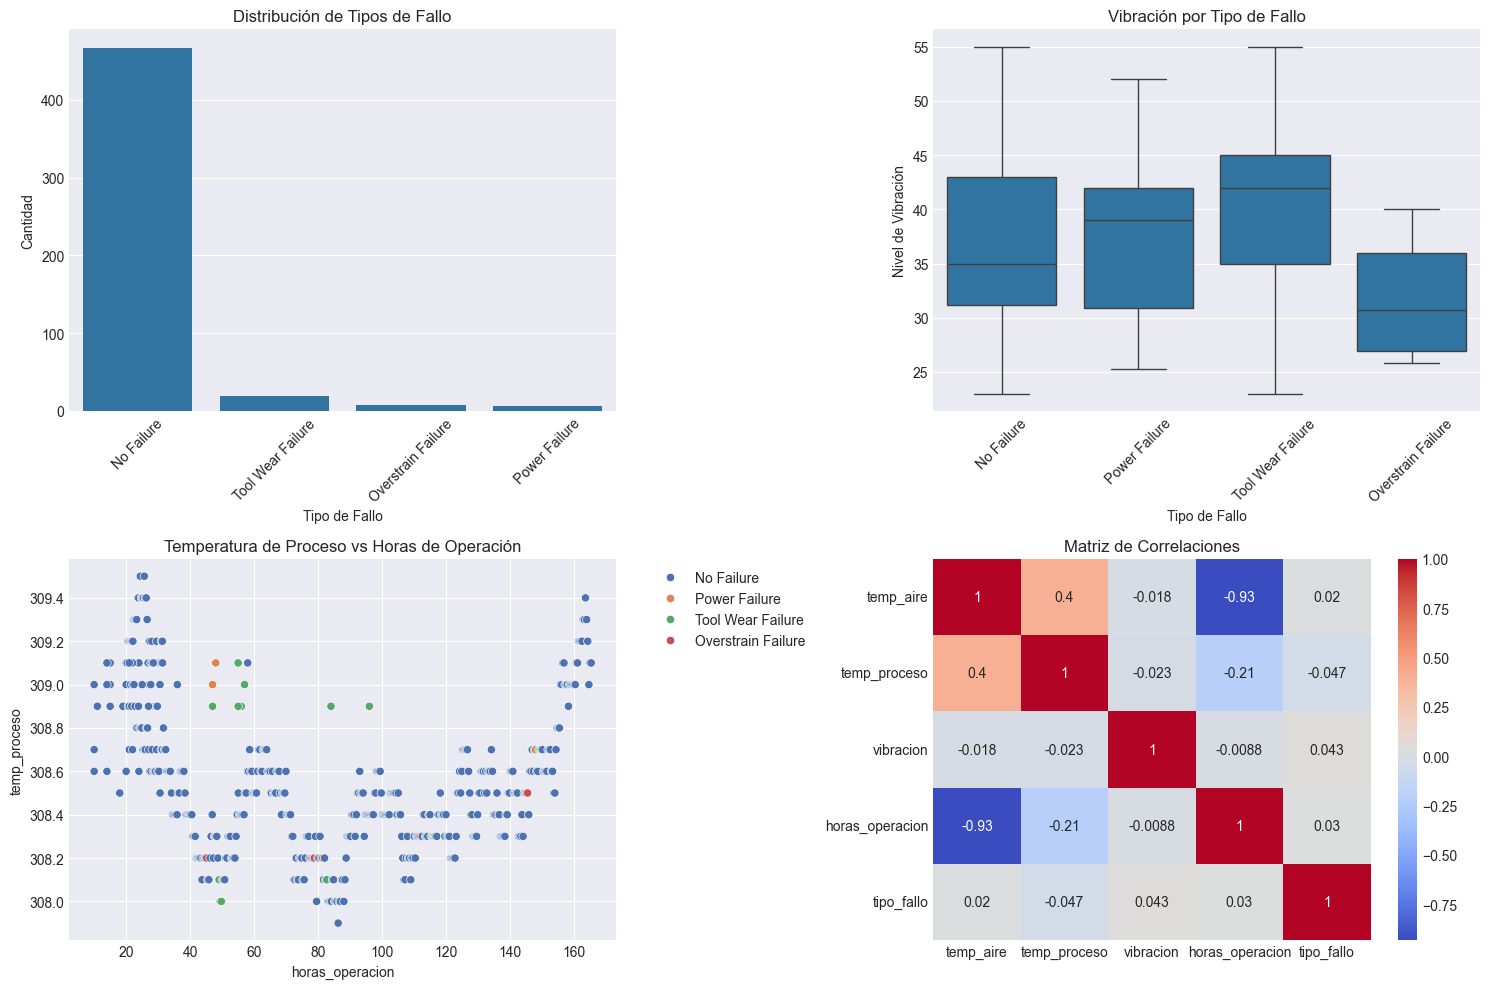

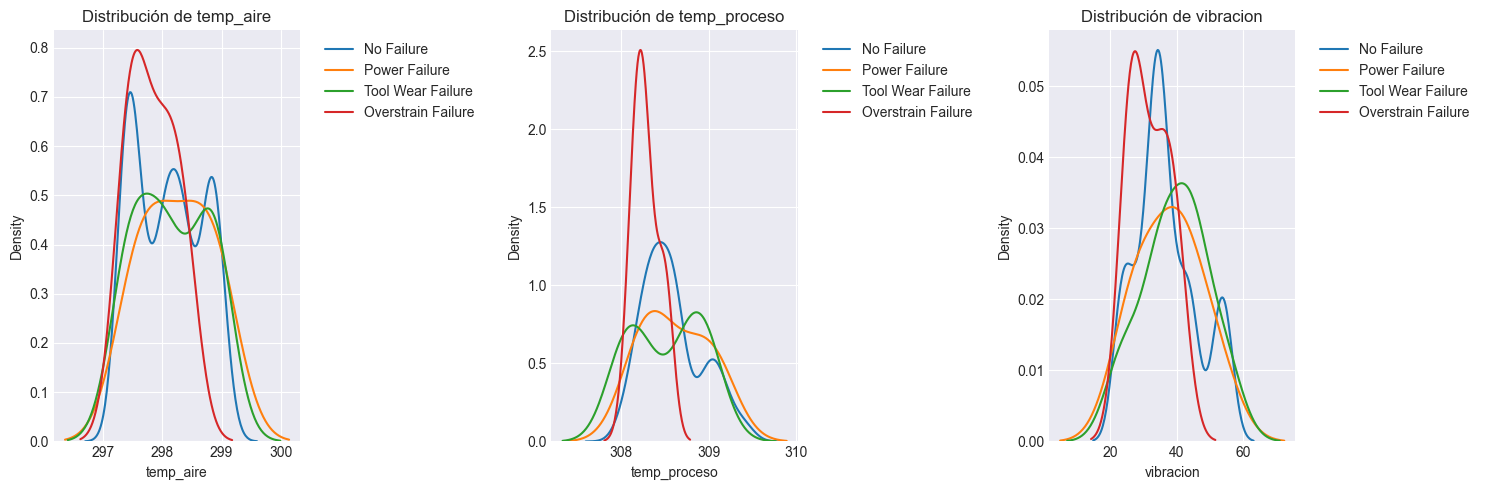

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3825 - auc_1: 0.5042 - loss: 16.3261 - val_accuracy: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 1.6907 - learning_rate: 0.0010
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5975 - auc_1: 0.5127 - loss: 10.2138 - val_accuracy: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 4.2333 - learning_rate: 0.0010
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6243 - auc_1: 0.4996 - loss: 3.9281 - val_accuracy: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 4.1692 - learning_rate: 0.0010
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6335 - auc_1: 0.4955 - loss: 3.5713 - val_accuracy: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 3.6373 - learning_rate: 0.0010
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6038 - auc_1: 0.4940 - loss: 2.9998 - val_accuracy: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 3.6045 - learning_rate: 0.0010
Epoch 6/100
38/38 ━━━━

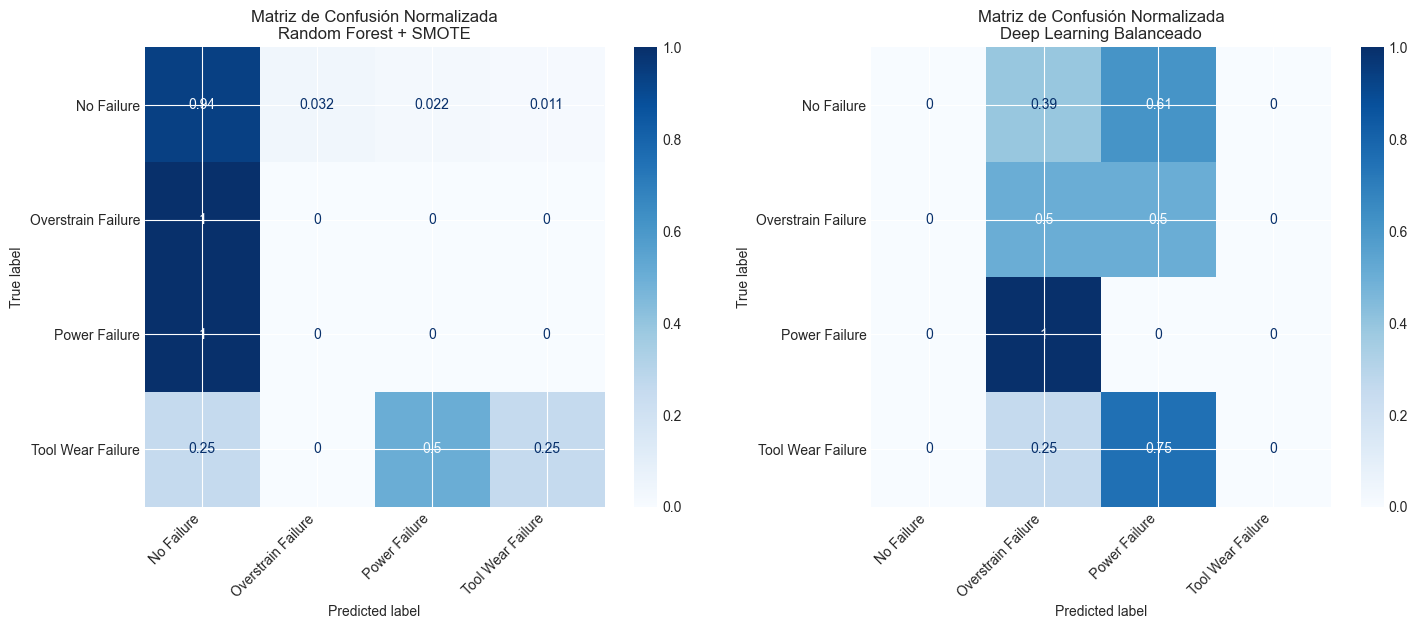

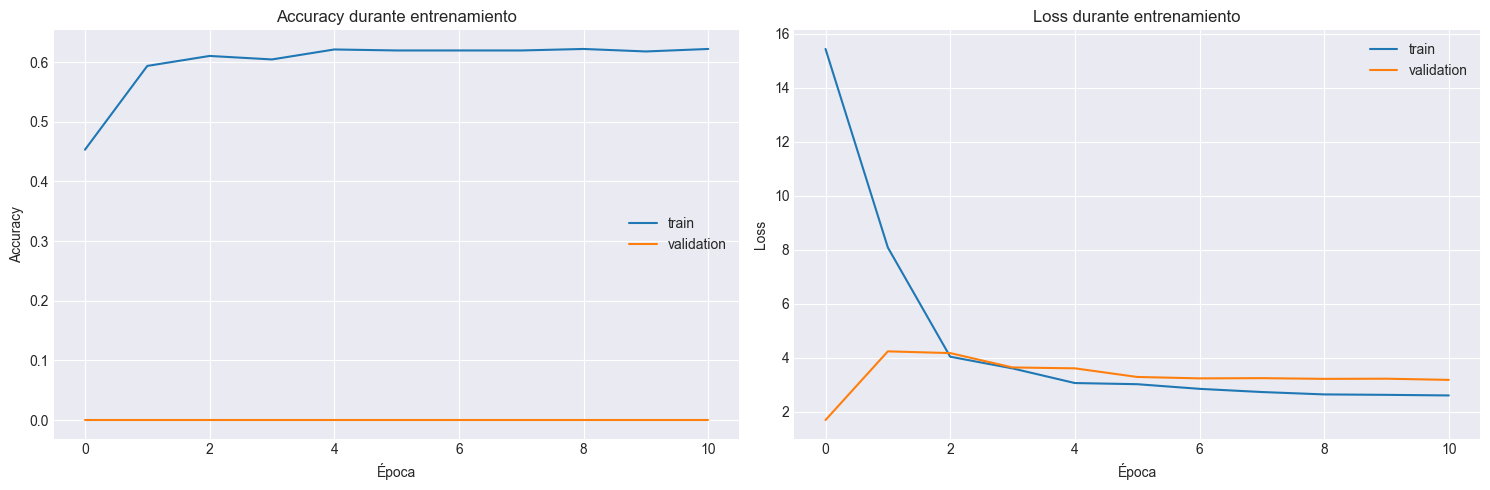


Reporte de Clasificación - Random Forest con SMOTE:
                    precision    recall  f1-score   support

        No Failure       0.96      0.94      0.95        93
Overstrain Failure       0.00      0.00      0.00         2
     Power Failure       0.00      0.00      0.00         1
 Tool Wear Failure       0.50      0.25      0.33         4

          accuracy                           0.88       100
         macro avg       0.36      0.30      0.32       100
      weighted avg       0.91      0.88      0.89       100


Reporte de Clasificación - Deep Learning con Balanceo:
                    precision    recall  f1-score   support

        No Failure       0.00      0.00      0.00        93
Overstrain Failure       0.03      0.50      0.05         2
     Power Failure       0.00      0.00      0.00         1
 Tool Wear Failure       0.00      0.00      0.00         4

          accuracy                           0.01       100
         macro avg       0.01      0.12      0

In [39]:
# Inicializar y cargar datos
analizador = AnalizadorEquipos()
datos = analizador.cargar_datos('Dataset_clean.csv')

# Análisis estadístico
stats = analizador.analisis_estadistico()
print("\nEstadísticas por tipo de fallo:")
print(stats['por_fallo'])

# Visualizar estadísticas
analizador.visualizar_estadisticas()

# Entrenar modelos
resultados = analizador.entrenar_modelos()